In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 14.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import json

dataset_name = 'annaluiza/MojoSnippets'
data_files = {"train": "MojoTrain-Formatado.json", "test": "MojoTest-Formatado.json"}
dataset = load_dataset(dataset_name, data_files=data_files, trust_remote_code=True)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = "meta-llama/CodeLlama-7b-Python-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    use_flash_attention_2 = False, #set to True you're using A100
    device_map={"": 0}, #device_map="auto" will cause a problem in the training,
    #device_map="auto",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
)

Wrong padding side:
LLMs are decoder-only architectures, meaning they continue to iterate on your input prompt. If your inputs do not have the same length, they need to be padded. Since LLMs are not trained to continue from pad tokens, your input needs to be left-padded. Make sure you also don’t forget to pass the attention mask to generate!

In [ ]:
import transformers

tokenizer = AutoTokenizer.from_pretrained(model_name, add_eos_token=True, add_bos_token=True, trust_remote_code=True, force_download=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, pad_to_multiple_of=8, mlm=False)

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

In [ ]:
print("Pad token set to:", tokenizer.pad_token)
print("Pad side set to:", tokenizer.padding_side)

Pad token set to: </s>
Pad side set to: left


In [ ]:
def formatting_func(example):
    text = f"### Input: {example['input']}\n ### Output: {example['output']}"
    return text

In [ ]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
tokenized_train_dataset = dataset['train'].map(generate_and_tokenize_prompt)
tokenized_val_dataset = dataset['test'].map(generate_and_tokenize_prompt)

238


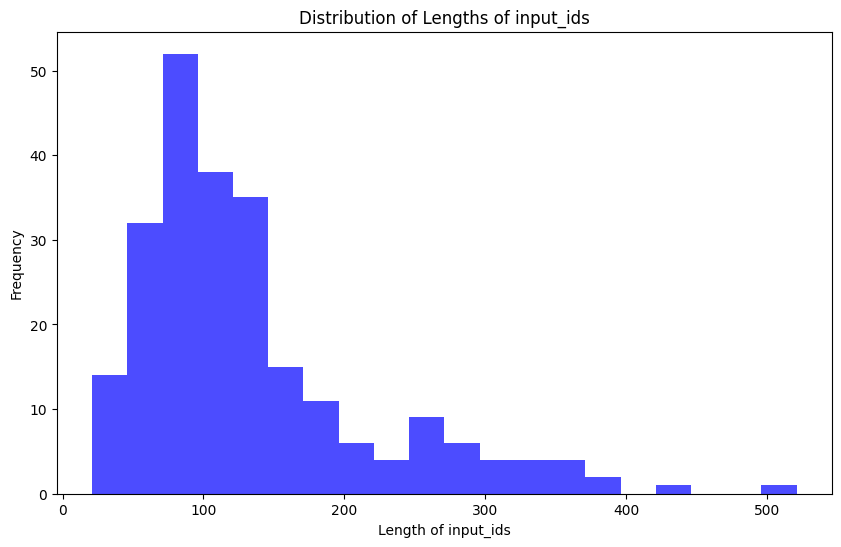

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 512

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result['attention_mask'].append(1)
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset_2 = dataset['train'].map(generate_and_tokenize_prompt2)
tokenized_val_dataset_2 = dataset['test'].map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_train_dataset_2[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

Agora veremos como o modelo se comporta antes do fine-tuning

In [ ]:
model_input = tokenizer("Write a function that takes two integers and returns their sum.", padding=True, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=50, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Write a function that takes two integers and returns their sum.Zygomaticus is a 19 year old male from the Netherlands. He is a very active and outgoing person. He is a very good listener and is very open to new experiences. He is very open minded and is very


In [ ]:
from peft import LoraConfig, get_peft_model

lora_alpha = 16
lora_dropout = 0.1
lora_r = 8

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
model.add_adapter(peft_config)

In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 2
gradient_accumulation_steps = 2
optim = "paged_adamw_8bit"
save_steps = 1
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch", #testar com "steps"
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=10,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    report_to="none",
    logging_strategy="epoch",
    logging_dir="./logs",
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [ ]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['input'])):
        text = f"### Input: {example['input'][i]}\n ### Output: {example['output'][i]}"
        output_texts.append(text)
    return output_texts

In [ ]:
from trl import SFTTrainer

max_seq_length = 512

trainer = SFTTrainer(
   model=model,
   #train_dataset=tokenized_train_dataset_2,
   #eval_dataset=tokenized_val_dataset_2,
   train_dataset=dataset['train'],
   eval_dataset=dataset['test'],
   #compute_metrics=compute_metrics, # testar se esse argumento é válido
   formatting_func=formatting_prompts_func,
   peft_config=peft_config,
   #dataset_text_field="input_ids",
   max_seq_length=max_seq_length,
   #tokenizer=tokenizer,
   args=training_arguments,
   data_collator=data_collator
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset_2,
    eval_dataset=tokenized_val_dataset_2,
    args=training_arguments,
    data_collator=data_collator,
)

In [ ]:
import gc
import os
# attempting to not run out of memory
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
gc.collect()

519

In [ ]:
# train model
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

# renable warnings
model.config.use_cache = True

Epoch,Training Loss,Validation Loss
1,1.855700,1.498158
2,1.130700,1.373902
3,0.824400,1.390114
4,0.618800,1.453007
5,0.464300,1.440210
6,0.362900,1.499684
7,0.282600,1.632338
8,0.241800,1.708561
9,0.194800,1.791104


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 121.06 MiB is free. Process 74888 has 14.63 GiB memory in use. Of the allocated memory 14.20 GiB is allocated by PyTorch, and 296.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# train model using base Trainer API
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

# renable warnings
model.config.use_cache = True

Epoch,Training Loss,Validation Loss
1,0.176700,1.798225


/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
!pip install -q rouge_score

  Preparing metadata (setup.py) ... done


In [ ]:
from datasets import load_metric
metric = load_metric('rouge', trust_remote_code=True)

<ipython-input-32-70feb98c4ec9>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge', trust_remote_code=True)


In [ ]:
# renable warnings
model.config.use_cache = True

In [ ]:
from transformers import pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

In [ ]:
gold_references = dataset['test']['output']

# Generate predictions using the model
model_predictions = [generator(input_text, max_new_tokens=50)[0]['generated_text'] for input_text in dataset['test']['input']]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
final_score = metric.compute(predictions=model_predictions, references=gold_references)

In [ ]:
final_score

{'rouge1': AggregateScore(low=Score(precision=0.23541568422905618, recall=0.5657105296674934, fmeasure=0.3247984959777564), mid=Score(precision=0.26221142695762106, recall=0.6156945460241123, fmeasure=0.3530861610540716), high=Score(precision=0.28985234800336385, recall=0.6622745490062053, fmeasure=0.38204651615384905)),
 'rouge2': AggregateScore(low=Score(precision=0.0784429086645336, recall=0.19607326016116947, fmeasure=0.10807336248300976), mid=Score(precision=0.09661890683289626, recall=0.23933843195535354, fmeasure=0.1324757323546965), high=Score(precision=0.11805805354396834, recall=0.2885901871540864, fmeasure=0.16089606738554377)),
 'rougeL': AggregateScore(low=Score(precision=0.1703716225892443, recall=0.41625497302698733, fmeasure=0.23549930791925053), mid=Score(precision=0.18754517963538103, recall=0.4604432972001853, fmeasure=0.2562547247216308), high=Score(precision=0.2076728805890508, recall=0.5114970390498667, fmeasure=0.27909600438146104)),
 'rougeLsum': AggregateScore(

In [ ]:
model_input = tokenizer(["Write a function that takes two integers and returns their sum."], padding=True, return_tensors='pt').to("cuda")
generated_id = model.generate(**model_input, max_new_tokens=50)
print(tokenizer.batch_decode(generated_id, skip_special_tokens=True)[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Write a function that takes two integers and returns their sum. Tags: c#, .net, wpf, xaml, data-binding

Question: How to bind a property to a different property in the same class?

I have a class that has two properties, `Name` and


In [ ]:
model_input = tokenizer("Calculates the nth number on a fibonnaci sequence.", return_tensors='pt').to("cuda")

model.eval()
with torch.no_grad():
  print(tokenizer.decode(model.generate(**model_input, max_new_tokens=50)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Calculates the nth number on a fibonnaci sequence. Tags: c#, .net, wpf, xaml, data-binding

Question: How to bind a property to a different property in the same class?

I have a class that has two properties, `Name` and
